In [1]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt
import timeit
import plotly.express as px

# Basic (cold) Raman

We will start with the simplest Raman protocol we can simulate, namely a 3 level lambda system, with stationary atoms and no four-wave mixing.

### First make the atom class

Setting **"Hyperfine splitting"** to False means that we will only simulate one level for the ground, intermediate excited state and storage state.

**"initial"** sets the initial state that we prepare the ensemble of atoms in. This assumes we are referring to one of the ground states of the atomic species we choose, so we need only specify the F number.

**"intermediate"** sets the intermediate excited state where the signal is near resonant (the precise detuning is specified later). Here we must define the principal quantum number of the state **n** and the total angular momentum quantum number **J**; we do not need to define the orbital quantum number **L** as this number must increase by 1 to be dipole allowed.

**"storage"** sets the state we wish to store into. Note that this does not need to be a ground state. We must specify **n** ,**L** and **F** to declare a ground state as the storage state, or **n** ,**L** and **J** if we wish to declare an excited state as the storage state. It's completely fine to specify all of the quantum numbers if you wish, thereby over specifying the state but the **Atom** class does not require you to do so.

From the **Atom** module we can call several classes: Rb87 (for 87 isotope of Rubidium), Rb85, Cs etc. Passing config to this class will work out all the various atom constants which will be used by the solver module.

In [2]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Alternatively we could make a Cs ensemble

# config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
#                                                     "storage": {"n":6 ,"L": 0, "F" : 3}}}
# atom = A.Cs(config)

In the **Atom** module, there are some useful functions.  For instance, computing the approximate optical depth for a given temperature and cell length. Note that when computing the optical depth, the function defaults to the ground->excited state transition. This may be changed (i.e. for telecom ORCA) by setting index=1, rather than the default index=0.

It should be noted that the optical depth defined in the simulation is half of the more standard definition.

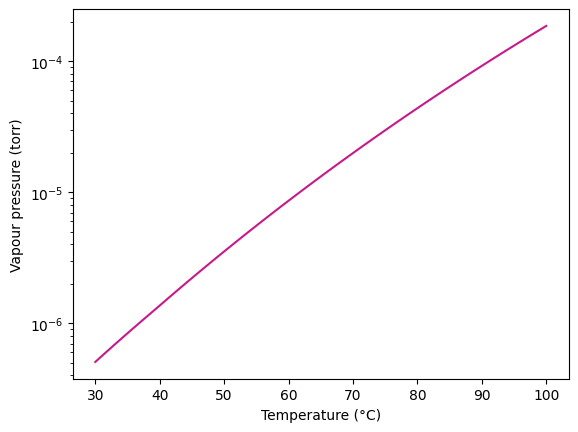

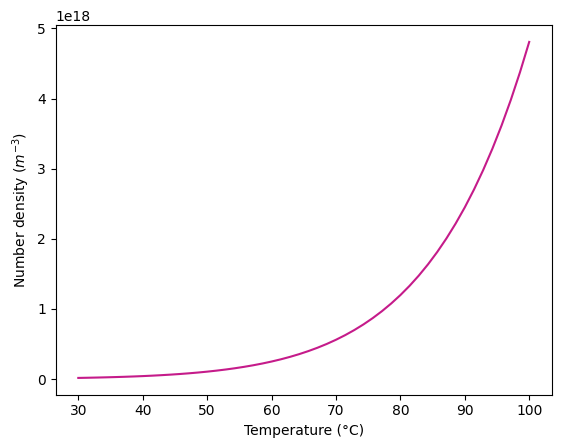

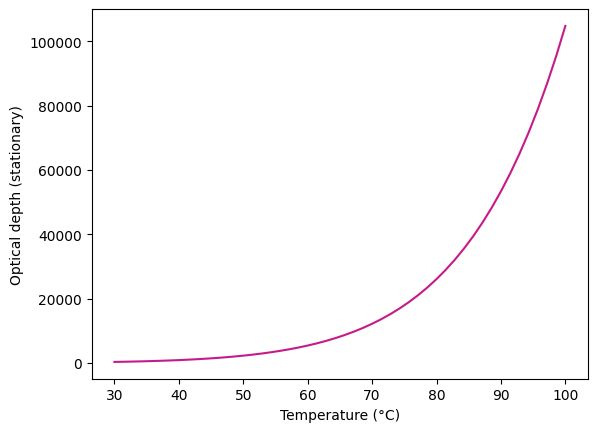

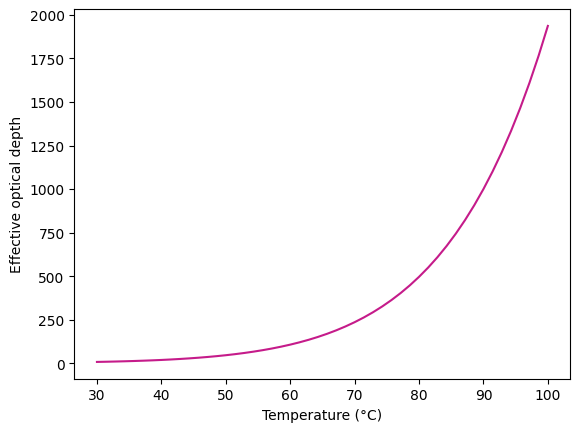

In [3]:
Ts = 273.15 + np.linspace(30, 100, 50)
vapour_pressure = atom.pV(Ts)
number_density = atom.Nv(Ts)

plt.plot(Ts - 273.15, vapour_pressure, color='#c51b8aff')
plt.yscale('log')
plt.ylabel('Vapour pressure (torr)')
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)')
plt.show()

plt.plot(Ts - 273.15, number_density, color='#c51b8aff')
plt.ylabel(u'Number density ($m^{-3}$)')
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)')
plt.show()


L = 0.075
ODs = atom.optical_depth(Ts, L)
ODdashes = atom.effective_optical_depth(ODs, Ts)

plt.plot(Ts - 273.15, ODs, color='#c51b8aff')
plt.ylabel(u'Optical depth (stationary)')
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)')
plt.show()

plt.plot(Ts - 273.15, ODdashes, color='#c51b8aff')
plt.ylabel(u'Effective optical depth')
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)')
plt.show()

We can also use the **Atom** module to convert Rabi frequency to intensity, power or the energy in a control pulse, or vice versa. Note that this is an approximation, again using the reduced dipole moment of a transition, and a radius for the control beam if the calculation required it. In these functions, the default is index=1. For TORCA, we would want index=0 to indicate the control coupling to the ground->excited state transition.

It should be noted that the Rabi frequency defined in the simulation is half of the more standard definition.

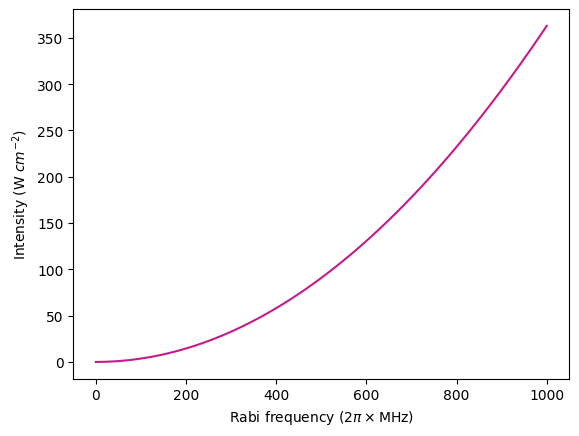

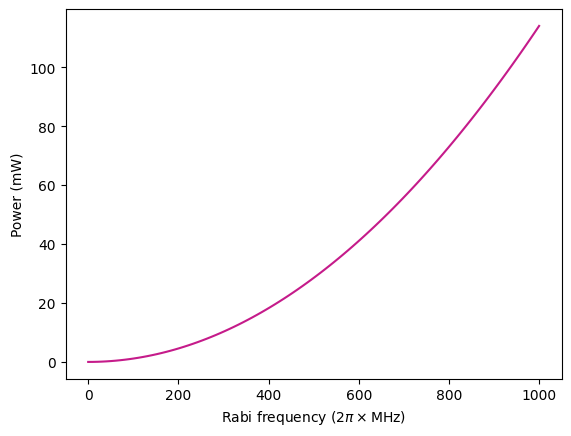

In [4]:
Omegas = np.linspace(0, 2*np.pi*1e9, 100) # list of rab frequencies

intensities = atom.rabi_frequency_to_intensity(Omegas) # cw intensity

plt.plot(Omegas/(2*np.pi*1e6), intensities/10000, color='#c51b8aff')
plt.ylabel(u'Intensity (W $cm^{-2}$)')
plt.xlabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.show()

beam_radius = 100e-6 # in m

powers = atom.rabi_frequency_to_power(Omegas, r=beam_radius) # cw power

plt.plot(Omegas/(2*np.pi*1e6), powers*1e3, color='#c51b8aff')
plt.ylabel(u'Power (mW)')
plt.xlabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.show()

Similarly we can convert intensity and power to Rabi frequency.

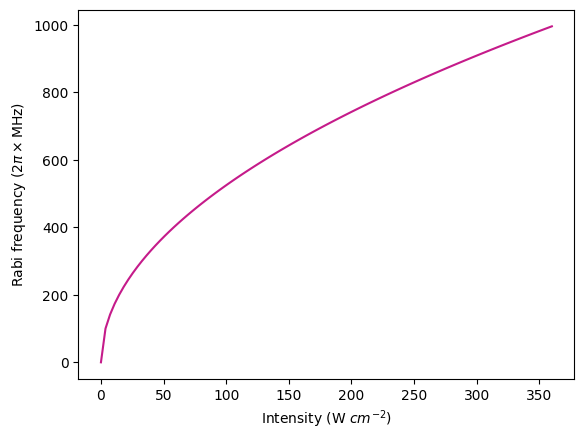

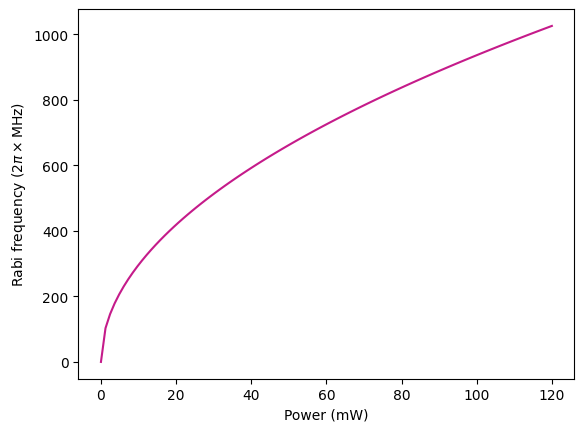

In [5]:
intensities = np.linspace(0, 360 * 10000, 100)

Omegas = atom.intensity_to_rabi_frequency(intensities)

plt.plot(intensities/10000, Omegas/(2*np.pi*1e6), color='#c51b8aff')
plt.ylabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.xlabel(u'Intensity (W $cm^{-2}$)')
plt.show()

beam_radius = 100e-6 # in m

powers = np.linspace(0, 120 * 1e-3, 100)

Omegas = atom.power_to_rabi_frequency(powers, r=beam_radius)

plt.plot(powers*1e3, Omegas/(2*np.pi*1e6), color='#c51b8aff')
plt.ylabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.xlabel(u'Power (mW)')
plt.show()

For pulse energies, we must define a temporal profile of the control pulse. We will use a built in gaussian function from the **Solver** module. More on tthe **Solver** module later.

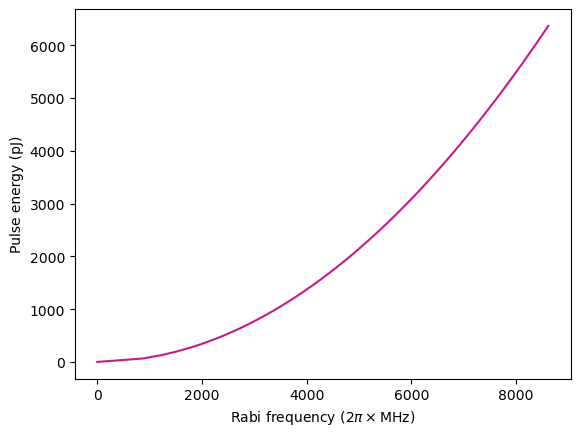

In [6]:
# times in seconds
tend = 8e-9
t0 = tend/2 # time of center of gaussian control 
tau = 1e-9 # FWHM of gaussian control

m = 500 # number of time steps
t = np.linspace(0, tend, m) # time axis

energies = []

for Omega in Omegas:
    energies.append( atom.control_pulse_to_energy(S.gaussian(t, t0, tau, Omega), t, r=beam_radius) )

plt.plot(Omegas/(2*np.pi*1e6), np.array(energies)*1e12, color='#c51b8aff')
plt.ylabel(u'Pulse energy (pJ)')
plt.xlabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.show()

We can use the **set_energy_of_control_pulse()** function to take the temporal profile of a control pulse and set its total energy. 

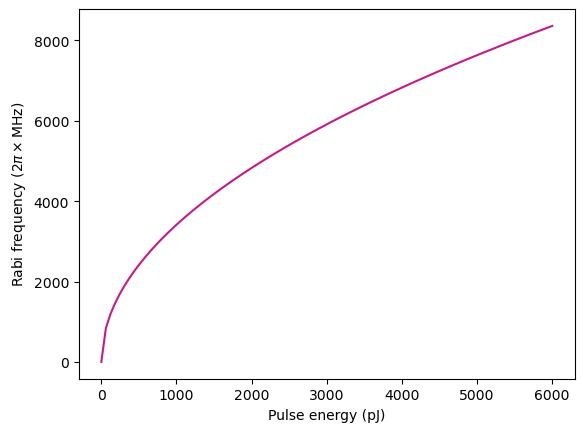

In [11]:
# times in seconds
tend = 8e-9
t0 = tend/2 # time of center of gaussian control 
tau = 1e-9 # FWHM of gaussian control

m = 500 # number of time steps
t = np.linspace(0, tend, m) # time axis

Control_shape = S.gaussian(t, t0, tau, 1) # temporal shape of control field

energies = np.linspace(0, 6e-9, 100) # energies in J
max_amplitude = []

for energy in energies:
    Control_new = atom.set_energy_of_control_pulse(energy, Control_shape, t, r=beam_radius)
    max_amplitude.append(np.max(np.abs(Control_new)))

plt.plot(energies*1e12, np.array(max_amplitude)/(2*np.pi*1e6), color='#c51b8aff')
plt.ylabel(r'Rabi frequency ($2\pi \times$MHz)')
plt.xlabel(u'Pulse energy (pJ)')
plt.show()

## Storage

### Setting up the solver class

Now that we have our atom class, we'll initialise the solver class from the **MEVeS** module. Here we will fully define our atomic ensemble, the optical fields and the memory protocol we wish to simulate.

We will define our atoms as cold, i.e. 0 temperature, and set the optical depth to 5000.

For defining the initial stored coherence between the two ground states (or spin wave), we define a 6D numpy array with shape 


(   number of space steps, number of hyperfine ground states in initial state, number of mF levels in starting state, 
    number of hyperfine states in the storage state, number of mF levels in storage state, number of velocity classes )

For our simple 3 level lambda case, with cold atoms, the shape will be:

( number of space steps, 1, 1, 1, 1, 1 )

See below.

In [12]:
OD = 5000 # optical depth of the ensemble
n = 50 # number of space steps. Note these are not evenly spaced.
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate. With a temperature of 0K, we should only simulate 1.
L = 0.075 # length of the cell in m

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

print(Sinits.shape)

(50, 1, 1, 1, 1, 1)


For our signal field, we will define a gaussian with a FWHM of 1ns. We must also define a polarisation. The polarisation vector should be of the form:

[left circular amplitude, right circular amplitude]

and should be normalised such that (left circular amplitude)^2 + (right circular amplitude)^2 = 1.

For example, horizontal polarisation can be defined as 

horizontal = np.sqrt(1/2)*np.array([1, 1])

and vertical as

vertical = np.sqrt(1/2)*np.array([1, -1])

For our simple 3 level lambda system, polarisation is not defined and we should use 

polarisation = np.array([1, 0])

If we instead use 

other_polarisation = np.array([0, 1])

this will not couple to the atoms.

We also use the built in **photon_gaussian** function when defining the signal field below. This will normalise our signal field such that there is only one input photon. Our final initial condition for the signal field will have shape:

(number of time steps, 2)

where 2 refers to the two polarisations.

In [27]:
photon_pol = np.array([1, 0]) #should be normalised

tau = 1e-9 # 1ns FWHM

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 2*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 200 # number of time steps
t = np.linspace(0, tend, m) # time axis

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # signal field initial condition
print(Einits.shape)

(200, 2)


The detuning of the signal field should be given in Hz

In [29]:
detuning = 2*np.pi*6e9
deltaS = detuning # detuning of the signal field

For the control field, we again define its temporal profile and detuning. We will choose the same as the signal field and a detuning equal to the signal field i.e. two photon resonance. Also, we define an amplitude in units of Rabi frequency.

In [30]:
deltaC = detuning # detuning of the control field

Omega = 2*np.pi*1e9 # peak rabi frequency
control_pol = np.array([1, 0])
Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

Finally we define the memory protocol and intialise the solver class.

In [31]:
protocol = 'Raman' # Memory protocol

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Before solving the simulation, we must indicate which direction the control field will propagate with respect to the signal. Since this is a 1D simulation, we have two choices: co-propagating or counter-propagating, each with their respective functions.

For the **co_prop()** function, we must define the control field amplitude with shape (number of time steps, 2). If no time axis is supplied, the function will assume the time axis that the **solver** class was initialised with. If however the control field is from a different simulation and so defined on a different time axis, the **co_prop()** function can optionally take a specified time axis, and will interpolate the control field onto the time axis the **solver** class was initialised with, i.e. the time axis that will be used for the simulation.

In [33]:
Control_tzp = sol.co_prop( Control_tp )

Now we are ready to solve. The **solve()** function only requires the control field returned by either the **co_prop()** or **counter_prop()** functions. Optionally, you may specify a method used in the solver.

In [34]:
sol.solve(Control_tzp, method='RK4-Ralston')

### Plotting

Plot the input and output photon field intensity. The electric field can be accessed through **sol.E** and has shape (m, n, 2).

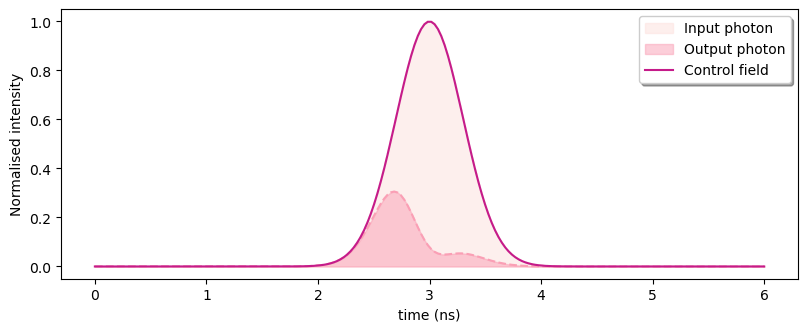

In [56]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

Plot initial and final spin wave as a function of z. The spin wave can be accessed through **sol.S** and has shape (m, n, 1, 1, 1, 1, 1) in this case.

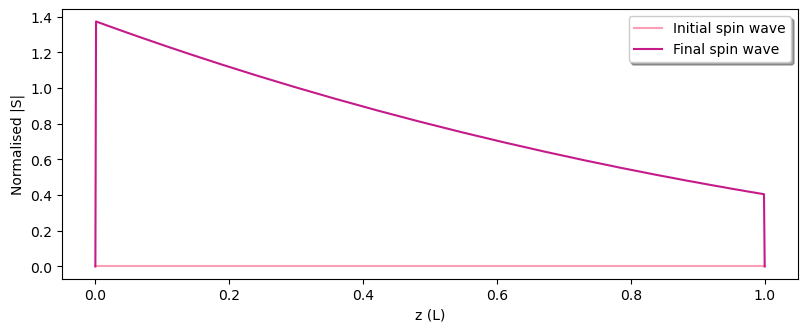

In [43]:
fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

We can also use some built in functions to compute the storage efficiency, or efficiency of leaked photon field.

For the storage efficiency, we must give the **storage_efficiency()** function the atomic coherence we wish to compute the efficiency for, which is in this case sol.S, as well as the time step we are interested in, e.g. the final time step of the simulation.

In [49]:
storage = sol.storage_efficiency(sol.S, mi=-1)
print(f"Storage efficiency = {storage*100: .2f} %")

Storage efficiency =  76.24 %


We can also use the **retrieval_efficiency()** function to compute the total amount of light output from the atomic ensemble. Here we must provide the function with the photonic coherence we are interested in (sol.E in this case), from what time step to begin the integration (we will choose 0) and for which polarisation.

In [51]:
leaked = sol.retrieval_efficiency(sol.E, mi=0, p=0)
print(f"Leaked efficiency = {leaked*100: .2f} %")

storage_from_leaked = 1-leaked
print(f"Storage efficiency (from leaked) = {storage_from_leaked*100: .2f} %")

Leaked efficiency =  23.53 %
Storage efficiency (from leaked) =  76.47 %


## Retrieval

If we wish to simulate retrieval, we can intialise a new solver class and pass the output spin wave from the storage as an initial condition.

In [52]:
Einits = np.zeros(m)[:, None] * photon_pol[None, :]

Sinits = sol.S[-1] # output spin wave from storage simulation

sol_ret = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Omega = 2*np.pi*1e9 # peak rabi frequency
Control_ret = S.gaussian(t, t0, tau, Omega)[:, None] * control_pol[None, :]

Control_tzp = sol_ret.co_prop( Control_ret )

sol_ret.solve(Control_tzp, method='RK4-Ralston')

retrieved = sol_ret.retrieval_efficiency(sol_ret.E, 0, 0)

print(f"Storage efficiency = {storage*100: .2f} %")
print(f"Total efficiency = {retrieved*100: .2f} %")
print(f"Retrieval efficiency = {(retrieved/storage)*100: .2f} %")

Storage efficiency =  76.24 %
Total efficiency =  45.98 %
Retrieval efficiency =  60.31 %


### Plots

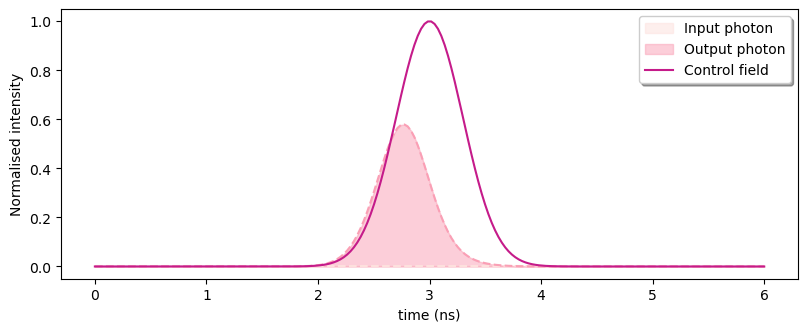

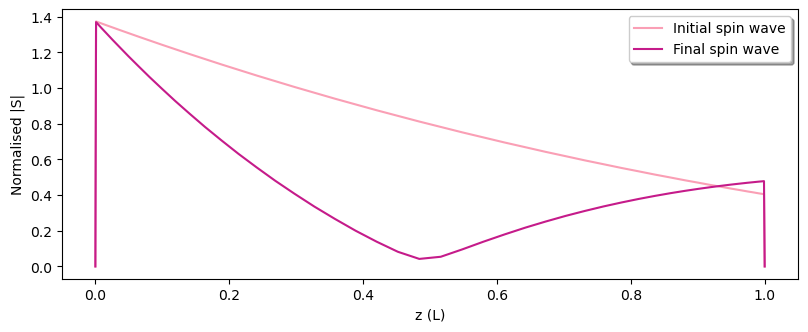

In [57]:
fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol_ret.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol_ret.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol_ret.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol_ret.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_ret[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol_ret.zCheby, np.abs(sol_ret.S[0, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Initial spin wave')
ax.plot(sol_ret.zCheby, np.abs(sol_ret.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

## Storage and retrieval

Instead of simulating the storage and retrieval processes separately, we can compute everything in the same simulation.

We will increase the end time of the simulation, and append the retrieval control field.

In [65]:
OD = 5000 # optical depth of the ensemble
n = 50 # number of space steps. Note these are not evenly spaced.
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate. With a temperature of 0K, we should only simulate 1.
L = 0.075 # length of the cell in m

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

photon_pol = np.array([1, 0]) #should be normalised

tau = 1e-9 # 1ns FWHM

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 200 # number of time steps
t = np.linspace(0, tend, m) # time axis

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*6e9
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

Omega_store = 2*np.pi*1e9 # peak rabi frequency of storage control pulse
Omega_retrieve = 2*np.pi*1e9 # peak rabi frequency of retrieval control pulse
control_pol = np.array([1, 0])

tr = 5e-9 # storage time

Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol_combined = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol_combined.co_prop( Control_tp )
sol_combined.solve(Control_tzp, method='RK4-Ralston')

In [88]:
storage = sol_combined.storage_efficiency(sol_combined.S, mi=m//2) # half way through simulation
retrieved = sol_combined.retrieval_efficiency(sol_combined.E, m//2, 0)

### Plots

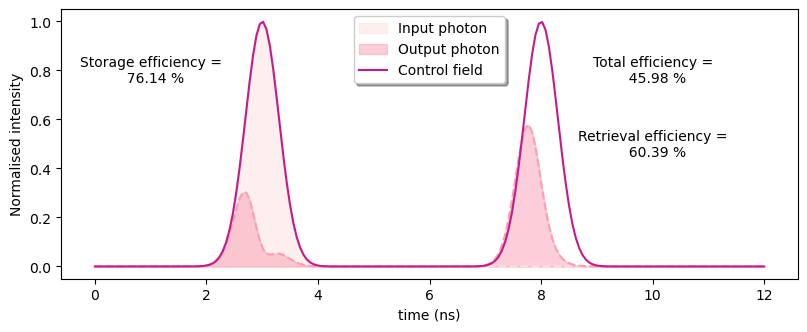

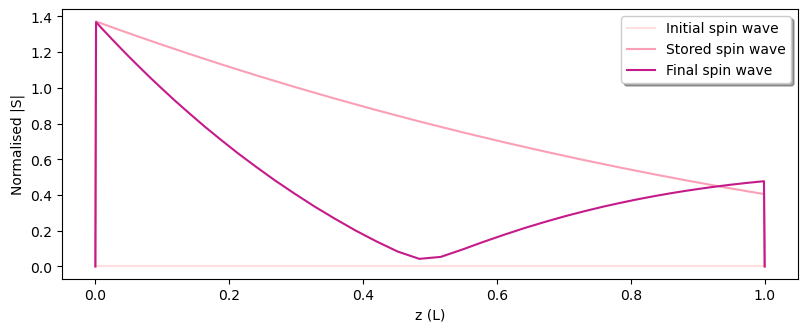

In [89]:
photon_norm = max(pow(np.abs(sol_combined.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol_combined.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol_combined.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol_combined.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol_combined.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol_combined.zCheby, np.abs(sol_combined.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol_combined.zCheby, np.abs(sol_combined.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol_combined.zCheby, np.abs(sol_combined.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

# Hot atoms and full hyperfine structure

We will now simulatea more realistic system, where the atoms have non zero temperature and so are allowed to move and we will consider the full hyperfine and magnetic sublevel structure.

Adding in Doppler broadening doesn't do anything particularly exciting for Raman.

To include the full level strucutre, we set **"Hyperfine splitting"** to True.

In [13]:
config = {"Hyperfine splitting": True, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

We will use the built in optical depth function to obtain a realistic optical depth for our Rb87 vapour at a particular temperature.

In [14]:
T = 273.15+90 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  53382
Effective OD =  1000


When defining the polarisation of the fields, we will choose the signal and control to be orthogonal and linearly polarised.

In [15]:
photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised

tau = 1e-9 # 1ns FWHM

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 200 # number of time steps
t = np.linspace(0, tend, m) # time axis

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*6e9
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

Omega_store = 2*np.pi*1e9 # peak rabi frequency of storage control pulse
Omega_retrieve = 2*np.pi*1e9 # peak rabi frequency of retrieval control pulse
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised

tr = 5e-9 # storage time

Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol_full = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

print(f"Population distribution among mF levels in initial state = {sol_full.pop}")

Control_tzp = sol_full.co_prop( Control_tp )
sol_full.solve(Control_tzp, method='RK4-Ralston')

Population distribution among mF levels in initial state = [[0.2 0.2 0.2 0.2 0.2]]


In [16]:
storage = sol_full.storage_efficiency(sol_full.S, mi=m//2) # half way through simulation
retrieved = sol_full.retrieval_efficiency(sol_full.E, m//2, 0)

### Plots

Below we plot the summation for the intensity in both polarisations.

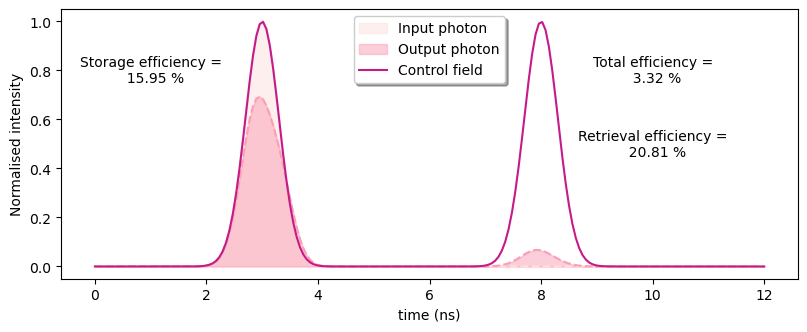

In [17]:
photon_norm = max(pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2))/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, 0, 0])**2 + np.abs(sol_full.E[:, 0, 1])**2) /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, -1, 0]),2) + pow(np.abs(sol_full.E[:, -1, 1]),2))/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, -1, 0])**2 + np.abs(sol_full.E[:, -1, 1])**2) /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, (np.abs(Control_tp[:, 0])**2 + np.abs(Control_tp[:, 1])**2)/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

# fig, ax = plt.subplots(figsize=(9.5, 3.5))

# ax.plot(sol_full.zCheby, np.abs(sol_full.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
# ax.set_ylabel('Normalised |S|', color='k')
# ax.set_xlabel('z (L)')
# plt.legend(loc='upper right', fancybox=True, shadow=True)
# plt.show()

We can look at the stored coherence for the different combinations of initial state mF and storage state mF.

In [18]:
sol_full.S.shape # shape is given by (m, n, 1, ground mF index, 1, storage mF index, velocity class index)

(200, 50, 1, 5, 1, 3, 30)

We will add up the coherence in each velocity class, at the midpoint of the simulation, i.e. after storage but before retrieval. Then by integrating over the length of the cell, the square of the spin wave for each pair of mF levels, we obtain the storage efficiency for each pair of mF levels. Summing this up gives us the storage efficiency quoted above.

In [19]:
S_sum_v = np.einsum('v, zgqv -> zgq', np.sqrt(sol_full.MB(sol_full.vs)*sol_full.dvs), sol_full.S[m//2, :, 0, :, 0, :, :])

efficiency_per_mF_pair = np.trapz( np.abs(S_sum_v)**2, x=sol_full.zCheby, axis=0 )

print(f"Storage efficiency (summing up all spin waves) = {np.sum(efficiency_per_mF_pair)*100: .2f} %")

Storage efficiency (summing up all spin waves) =  15.95 %


We can also plot the efficiency for each pair of mF levels. We can use the **Atom** class to obtain the correct mF values for each of the mF states.

In [20]:
print(f"Initial ground state mF levels = {atom.mg}")
print(f"Storage state mF levels = {atom.mq}")

Initial ground state mF levels = [-2 -1  0  1  2]
Storage state mF levels = [-1  0  1]


The array **efficiency_per_mF_pair** refers to the initial ground state mF in its first axis and the storage state mF in its second.

In [21]:
efficiency_per_mF_pair.shape
print(f"efficiency_per_mF_pair shape = {efficiency_per_mF_pair.shape}")
print(f"Number of ground state mF levels = {len(atom.mg)}")
print(f"Number of storage state mF levels = {len(atom.mq)}")

efficiency_per_mF_pair shape = (5, 3)
Number of ground state mF levels = 5
Number of storage state mF levels = 3


In [25]:
fig = px.imshow(efficiency_per_mF_pair.T*100, text_auto = '.2f', x = atom.mg, y = atom.mq, color_continuous_scale='RdPu')
fig.update_xaxes(side="top")
fig.update_layout(width = 800,height = 800, font=dict(size=16), yaxis={'tickvals': atom.mq})
fig.show(renderer = 'vscode')

### Change signal and control polarisation

What if we use orthogonal circular polarised signal and control?

In [36]:
photon_pol = np.array([1, 0]) # Left circularly polarised

tau = 1e-9 # 1ns FWHM

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 200 # number of time steps
t = np.linspace(0, tend, m) # time axis

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*6e9
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

Omega_store = 2*np.pi*1e9 # peak rabi frequency of storage control pulse
Omega_retrieve = 2*np.pi*1e9 # peak rabi frequency of retrieval control pulse
control_pol = np.array([0, 1]) # Right circularly polarised

tr = 5e-9 # storage time

Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol_full = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

print(f"Population distribution among mF levels in initial state = {sol_full.pop}")

Control_tzp = sol_full.co_prop( Control_tp )
sol_full.solve(Control_tzp, method='RK4-Ralston')

Population distribution among mF levels in initial state = [[0.2 0.2 0.2 0.2 0.2]]


In [37]:
storage = sol_full.storage_efficiency(sol_full.S, mi=m//2) # half way through simulation
retrieved = sol_full.retrieval_efficiency(sol_full.E, m//2, 0)

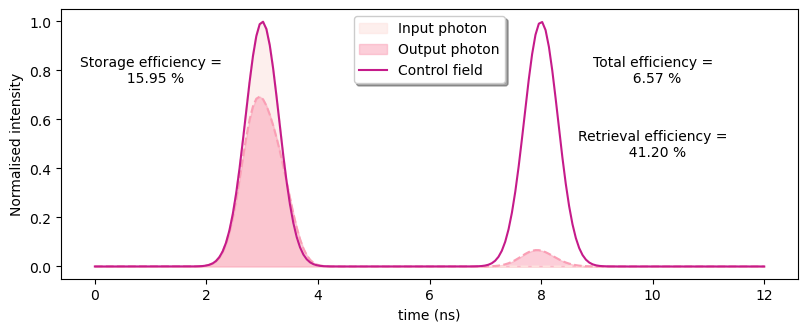

In [38]:
photon_norm = max(pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2))/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, 0, 0])**2 + np.abs(sol_full.E[:, 0, 1])**2) /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, -1, 0]),2) + pow(np.abs(sol_full.E[:, -1, 1]),2))/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, -1, 0])**2 + np.abs(sol_full.E[:, -1, 1])**2) /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, (np.abs(Control_tp[:, 0])**2 + np.abs(Control_tp[:, 1])**2)/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

# fig, ax = plt.subplots(figsize=(9.5, 3.5))

# ax.plot(sol_full.zCheby, np.abs(sol_full.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
# ax.set_ylabel('Normalised |S|', color='k')
# ax.set_xlabel('z (L)')
# plt.legend(loc='upper right', fancybox=True, shadow=True)
# plt.show()

In [39]:
S_sum_v = np.einsum('v, zgqv -> zgq', np.sqrt(sol_full.MB(sol_full.vs)*sol_full.dvs), sol_full.S[m//2, :, 0, :, 0, :, :])

efficiency_per_mF_pair = np.trapz( np.abs(S_sum_v)**2, x=sol_full.zCheby, axis=0 )

print(f"Storage efficiency (summing up all spin waves) = {np.sum(efficiency_per_mF_pair)*100: .2f} %")

Storage efficiency (summing up all spin waves) =  15.95 %


In [40]:
fig = px.imshow(efficiency_per_mF_pair.T*100, text_auto = '.2f', x = atom.mg, y = atom.mq, color_continuous_scale='RdPu')
fig.update_xaxes(side="top")
fig.update_layout(width = 800,height = 800, font=dict(size=16), yaxis={'tickvals': atom.mq})
fig.show(renderer = 'vscode')

### Use parallel signal and control polarisation

Here we expect there to be no memory.

In [42]:
photon_pol = np.sqrt(1/2)*np.array([1, 1]) # horizontal polarised

tau = 1e-9 # 1ns FWHM

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 200 # number of time steps
t = np.linspace(0, tend, m) # time axis

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*6e9
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

Omega_store = 2*np.pi*1e9 # peak rabi frequency of storage control pulse
Omega_retrieve = 2*np.pi*1e9 # peak rabi frequency of retrieval control pulse
control_pol = np.sqrt(1/2)*np.array([1, 1]) # horizontal polarised

tr = 5e-9 # storage time

Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol_full = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

print(f"Population distribution among mF levels in initial state = {sol_full.pop}")

Control_tzp = sol_full.co_prop( Control_tp )
sol_full.solve(Control_tzp, method='RK4-Ralston')

Population distribution among mF levels in initial state = [[0.2 0.2 0.2 0.2 0.2]]


In [43]:
storage = sol_full.storage_efficiency(sol_full.S, mi=m//2) # half way through simulation
retrieved = sol_full.retrieval_efficiency(sol_full.E, m//2, 0)

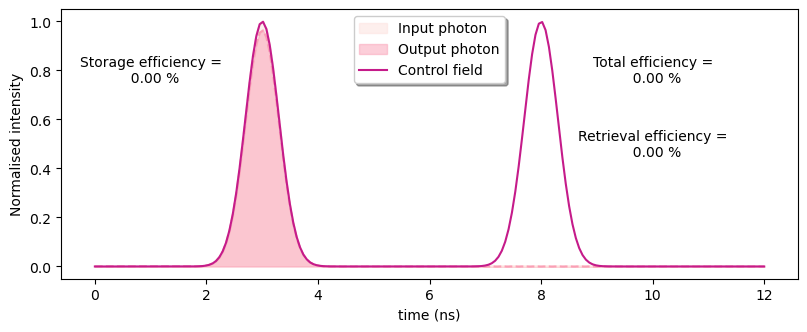

In [44]:
photon_norm = max(pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, 0, 0]),2) + pow(np.abs(sol_full.E[:, 0, 1]),2))/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, 0, 0])**2 + np.abs(sol_full.E[:, 0, 1])**2) /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, (pow(np.abs(sol_full.E[:, -1, 0]),2) + pow(np.abs(sol_full.E[:, -1, 1]),2))/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol_full.E[:, -1, 0])**2 + np.abs(sol_full.E[:, -1, 1])**2) /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, (np.abs(Control_tp[:, 0])**2 + np.abs(Control_tp[:, 1])**2)/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

# fig, ax = plt.subplots(figsize=(9.5, 3.5))

# ax.plot(sol_full.zCheby, np.abs(sol_full.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
# ax.plot(sol_full.zCheby, np.abs(sol_full.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
# ax.set_ylabel('Normalised |S|', color='k')
# ax.set_xlabel('z (L)')
# plt.legend(loc='upper right', fancybox=True, shadow=True)
# plt.show()

In [45]:
S_sum_v = np.einsum('v, zgqv -> zgq', np.sqrt(sol_full.MB(sol_full.vs)*sol_full.dvs), sol_full.S[m//2, :, 0, :, 0, :, :])

efficiency_per_mF_pair = np.trapz( np.abs(S_sum_v)**2, x=sol_full.zCheby, axis=0 )

print(f"Storage efficiency (summing up all spin waves) = {np.sum(efficiency_per_mF_pair)*100: .2f} %")

Storage efficiency (summing up all spin waves) =  0.00 %


In [46]:
fig = px.imshow(efficiency_per_mF_pair.T*100, text_auto = '.2f', x = atom.mg, y = atom.mq, color_continuous_scale='RdPu')
fig.update_xaxes(side="top")
fig.update_layout(width = 800,height = 800, font=dict(size=16), yaxis={'tickvals': atom.mq})
fig.show(renderer = 'vscode')